# Import Datasets and Dependencies

In [1]:
%%capture
!pip install ujson
!pip install trimesh
import trimesh
!pip install open3d
!pip install plyfile
import plyfile
import open3d
import matplotlib.pyplot as plt
import matplotlib
import ujson
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm.notebook as tqdm
import math
import random
import time
import copy
import numpy as np
import os
!pip install pyntcloud # Pythonic PointCloud Library
import pandas as pd
import pyntcloud
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load in the Datasets

In [2]:
%%capture
# 3D Classification is the ModelNet10 Dataset
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
!unzip ModelNet10.zip
!rm -f ModelNet10.zip
!rm -rf ./__MACOSX/ # Colab doesn't use a Mac, so these are just unnecessary files
!rm -rf ./sample_data # Remove sample datasets we don't need

In [3]:
%%capture
# The Object Part segmentation dataset is of course ShapeNet(The only one available)
!wget https://shapenet.cs.stanford.edu/media/shapenetcore_partanno_segmentation_benchmark_v0_normal.zip --no-check-certificate
!unzip shapenetcore_partanno_segmentation_benchmark_v0_normal.zip
!rm -f shapenetcore_partanno_segmentation_benchmark_v0_normal.zip

In [2]:
# How to easily display the pointclouds using PyntCloud
def display_pointcloud(points):
  df = pd.DataFrame(points, columns = ['x', 'y', 'z'])
  pc = pyntcloud.PyntCloud(df)
  pc.plot()

# Process in Model Net 10





In [3]:
# load in all files
def model_net_10():
  idx_to_class = {}
  class_to_idx = {}
  ex_per_class = 1
  class_count = 0
  train_loader = []
  base_dir = './ModelNet10'
  for class_item in os.listdir(base_dir):
    if os.path.isdir(base_dir + '/' + class_item):
      class_to_idx[class_item] = class_count
      idx_to_class[class_count] = class_item
      class_path = base_dir + '/' + class_item + '/train/'
      count = 0
      for item in os.listdir(class_path):
        train_loader += [{class_path + item: class_count}]
        count += 1
        if count == ex_per_class:
          break
      class_count += 1
  return idx_to_class, class_to_idx, train_loader
modelNet_idx_to_class, modelNet_class_to_idx, modelNet_train_loader = model_net_10()

In [4]:
def load_model_net(file):
  '''
  Loads in a ModelNet10 .off file into a numpy array
  '''
  mesh = open3d.io.read_triangle_mesh(file)
  return np.array(mesh.sample_points_poisson_disk(1000).points)

Class: table


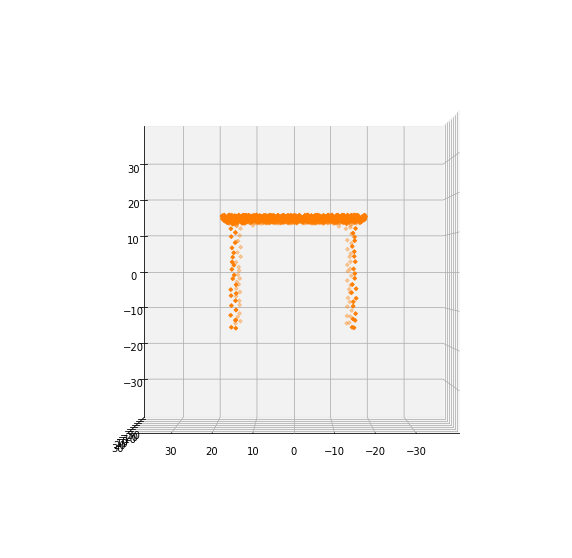

Class: bed


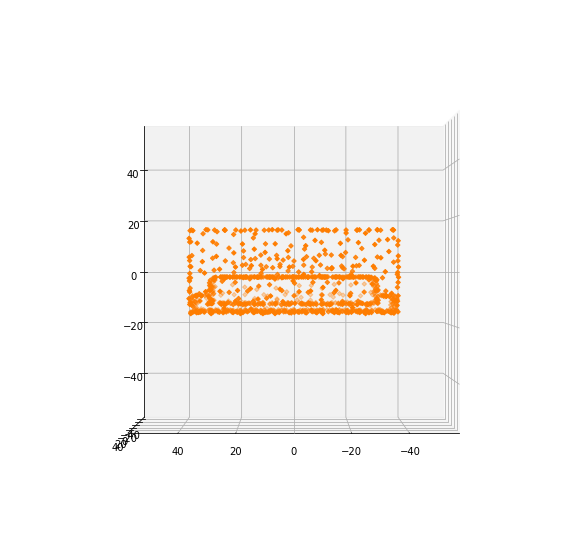

Class: monitor


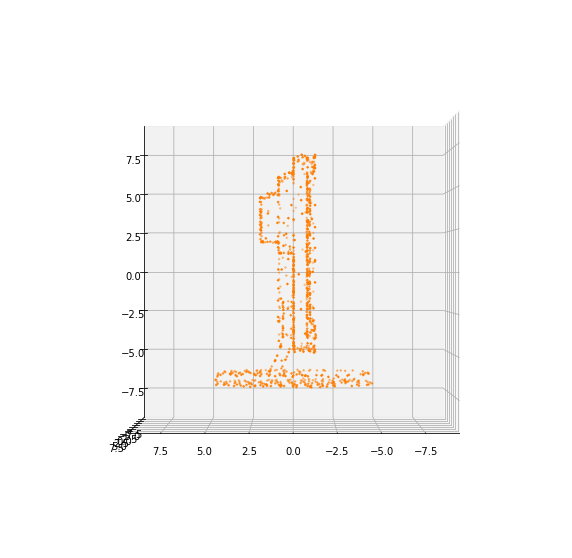

Class: desk


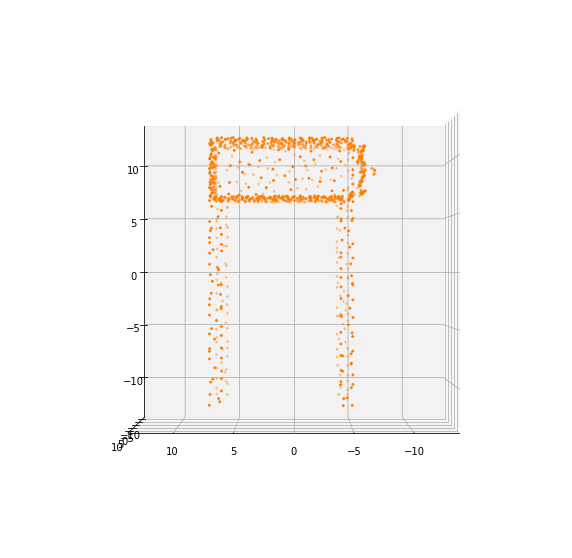

Class: bathtub


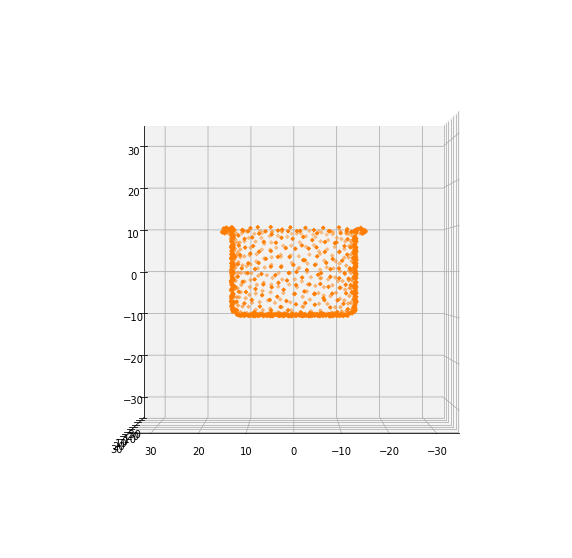

Class: dresser


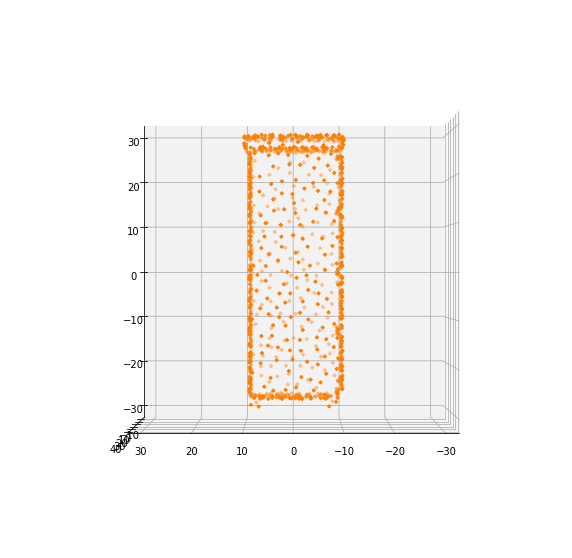

Class: night_stand


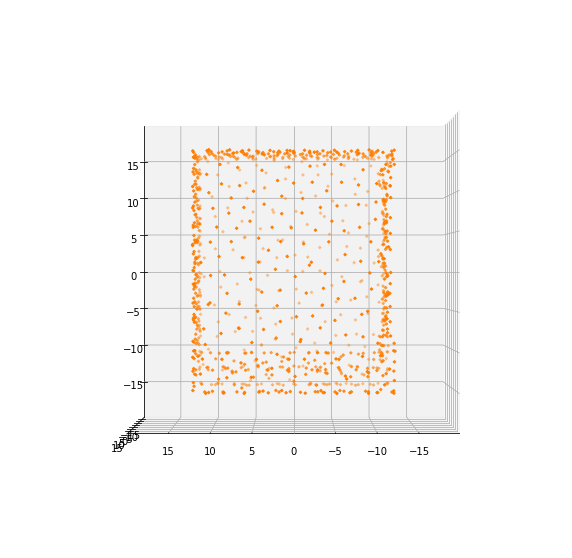

Class: sofa


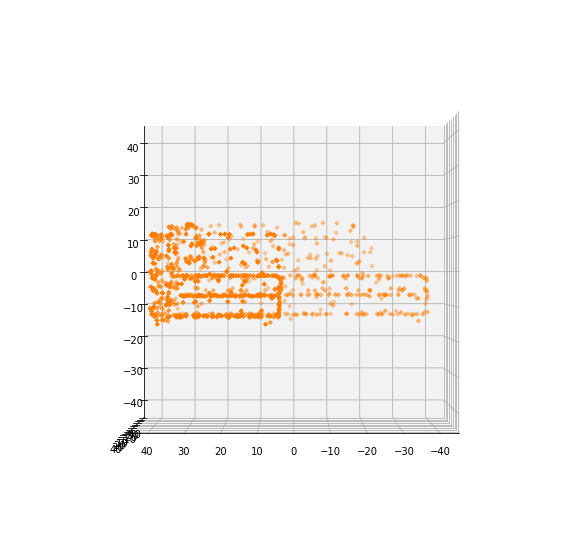

Class: chair


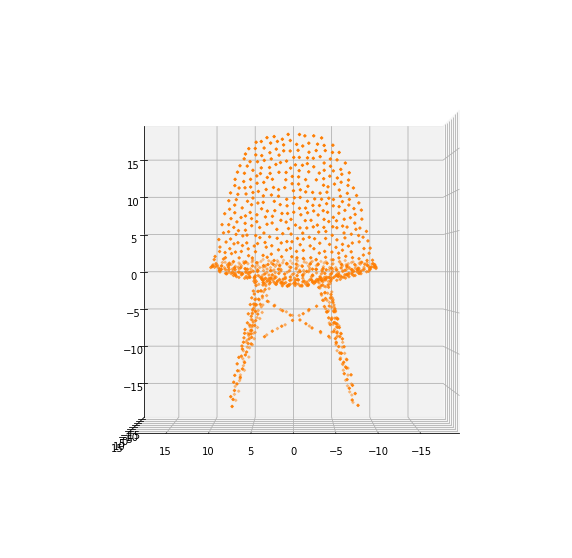

Class: toilet


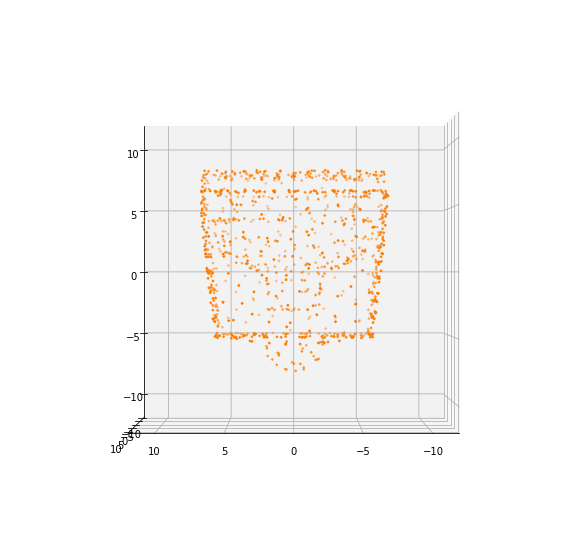

In [5]:
# Visualize Dataset as point clouds
visualized = []
for ex in modelNet_train_loader:
  for file_path in ex:
    class_idx = ex[file_path]
  if class_idx in visualized:
    continue
  visualized += [class_idx]
  class_name = modelNet_idx_to_class[class_idx]
  print(f"Class: {class_name}")
  point_cloud_array = load_model_net(file_path)
  display_pointcloud(point_cloud_array)

In [6]:
# Plots a point cloud with a segmentation mask(Using Matplotlib)
def display_with_seg_mask(points):
  '''
  points: (N, 4) in form (X, Y, Z, class)
  '''
  rgb_colour_set = []
  for colour in matplotlib.colors.cnames.items(): # This has 147 colours, way more than what we need
    rgb_colour_set += [matplotlib.colors.to_rgb(colour[1])] # colour[1] is the hex value
  rgb_colour_set = np.array(rgb_colour_set)
  classes = np.array(points[:, -1].tolist(), dtype = np.int32)
  colours = rgb_colour_set[classes]
  x = points[:, 0]
  y = points[:, 1]
  z = points[:, 2]
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  
  ax.scatter(x, y, z, c = colours)
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')

  plt.show()


# Process in ShapeNet

In [7]:
category_to_origId = {
        "Airplane": "02691156",
        "Bag": "02773838",
        "Cap": "02954340",
        "Car": "02958343",
        "Chair": "03001627",
        "Earphone": "03261776",
        "Guitar": "03467517",
        "Knife": "03624134",
        "Lamp": "03636649",
        "Laptop": "03642806",
        "Motorbike": "03790512",
        "Mug": "03797390",
        "Pistol": "03948459",
        "Rocket": "04099429",
        "Skateboard": "04225987",
        "Table": "04379243",
    }
origId_to_class = {}
id_to_class = {}
class_to_id = {}
count = 0
for i in category_to_origId:
  id_to_class[count] = i
  class_to_id[i] = count
  origId_to_class[category_to_origId[i]] = i 
  count += 1
class_to_segPointId = {
    "Airplane": [0, 1, 2, 3],
    "Bag": [4, 5],
    "Cap": [6, 7],
    "Car": [8, 9, 10, 11],
    "Chair": [12, 13, 14, 15],
    "Earphone": [16, 17, 18],
    "Guitar": [19, 20, 21],
    "Knife": [22, 23],
    "Lamp": [24, 25, 26, 27],
    "Laptop": [28, 29],
    "Motorbike": [30, 31, 32, 33, 34, 35],
    "Mug": [36, 37],
    "Pistol": [38, 39, 40],
    "Rocket": [41, 42, 43],
    "Skateboard": [44, 45, 46],
    "Table": [47, 48, 49],
}
num_seg_classes = 50
segPointId_to_class = {}
for class_name in class_to_segPointId:
  for point_id in class_to_segPointId[class_name]:
    segPointId_to_class[point_id] = class_name
# these represent the segmentation classes, To be Honest, they don't do much, it does tell us that there is 50 total segmentation classes
base_folder = './shapenetcore_partanno_segmentation_benchmark_v0_normal'
count_per_folder = 2
training_set = {}
for extension in os.listdir(path = base_folder):
  if not extension.isnumeric():
    continue
  folder = base_folder + '/'+ extension
  count = 0
  sample = []
  for model in os.listdir(path = folder):
    sample += [folder + '/' + model]
    count += 1
    if count == count_per_folder:
      break
  training_set[origId_to_class[extension]] = sample

In [8]:
def load_in_shapenet(file_path):
  XYZC_points = [] # will contain X, Y, Z and Class for this certain point
  with open(file_path) as file:
    for line in file:
      values = line.split()
      XYZC_points += [[float(values[0]), float(values[1]), float(values[2]), float(values[-1])]]
  return np.array(XYZC_points, order = 'C')

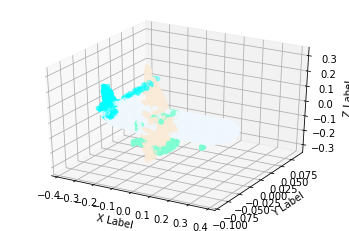

Airplane


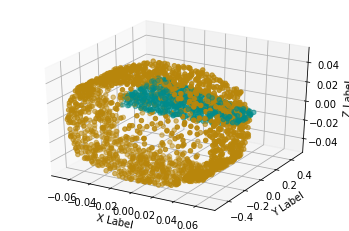

Knife


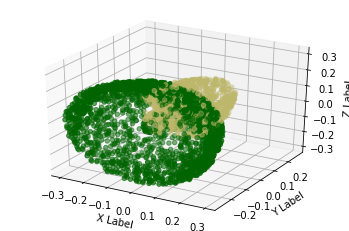

Lamp


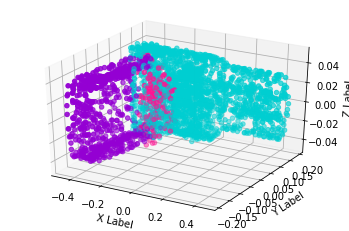

Pistol


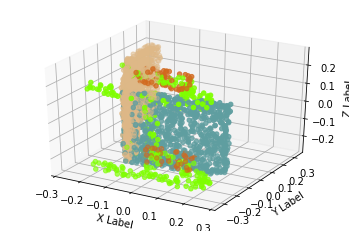

Chair


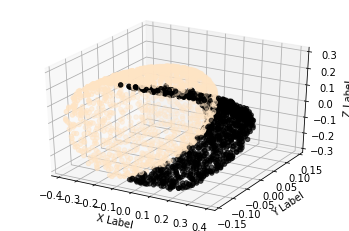

Cap


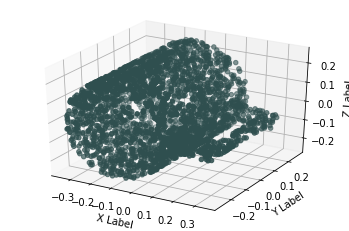

Mug


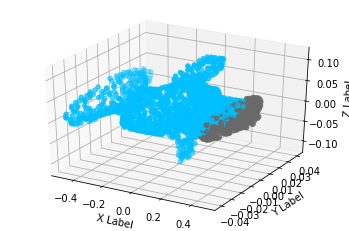

Rocket


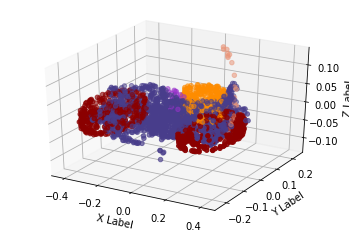

Motorbike


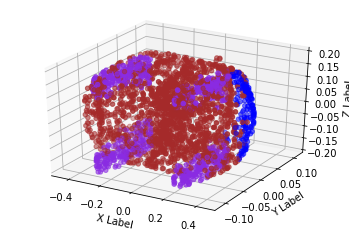

Car


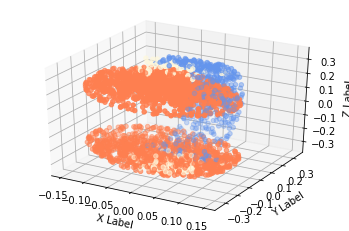

Earphone


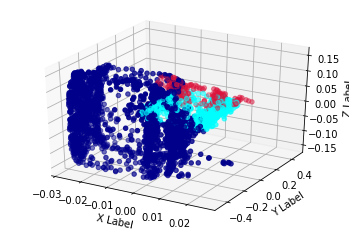

Guitar


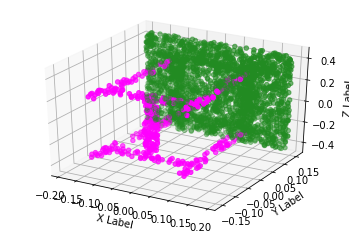

Table


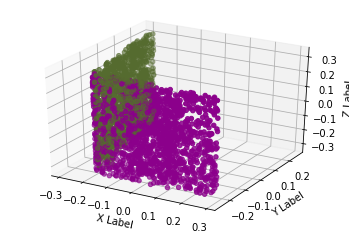

Laptop


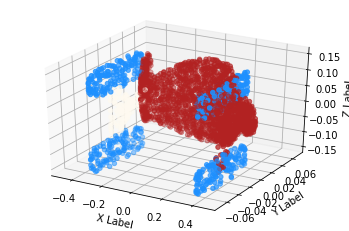

Skateboard


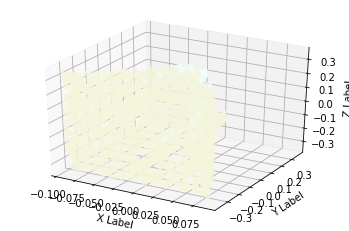

Bag


In [9]:
# Visualize ShapeNet Dataset(without seg classes)
for ex in training_set:
  points = load_in_shapenet(training_set[ex][0])
  display_with_seg_mask(points)
  print(ex)
  continue

Take a look at input sizes being inputted into the model

In [10]:
# Process training_set to get a trainloader
trainloaderShapeNet = []
for class_name in training_set:
  # We will map file to class, but this doesn't exactly matter too much, as the goal of this dataset is to simply segment each of the points
  for file_name in training_set[class_name]:
    trainloaderShapeNet += [{file_name: class_to_id[class_name]}]


In [ ]:
trainloaderShapeNet

In [12]:
for ex in modelNet_train_loader:
  for file_path in ex:
    pass
  arr = load_model_net(file_path)
  print(f"Model Net Input: {arr.shape}") # Always (1000, 3) in ModelNet
  break
for class_type in training_set:
  file_path = training_set[class_type][0]
  arr = load_in_shapenet(file_path)
  print(f"ShapeNet: {arr.shape}") # Varying Input size (N, 4) in ShapeNet, input will be (N, 3) since 4th val is the GT score
  break

Model Net Input: (1000, 3)
ShapeNet: (2579, 4)


# Part 1: Point Net Vanilla

In [13]:
class PointResBlock(nn.Module):
  '''
  Block I thought of just to help gradients flow back better
  2 Level Conv1D blocks with a residual connection, batchnorm and relu
  '''
  def __init__(self, channels_in, channels_out):
    super().__init__()
    self.conv1 = nn.Conv1d(channels_in, channels_out, kernel_size = 1)
    self.conv2 = nn.Conv1d(channels_out, channels_out, kernel_size = 1)
    self.norm = nn.BatchNorm1d(channels_out)
  def forward(self, x, res = True):
    conv1 = self.conv1(x)
    if not res:
      conv1 = F.relu(conv1)
      conv2 = self.norm(F.relu(self.conv2(conv1)))
      return conv2
    return self.norm(F.relu(self.conv2(conv1) + conv1))

In [14]:
class PointNet(nn.Module):
  '''
  This is a pretty simple point net model, using 1x1 convolutions to paralelly process each point
  '''
  def __init__(self, num_classes, segmentation, device, residual = True, visual_transformer = True):
    '''
    This is PointNet Vanilla/Complete, with or without a visual transformer
    Architecture Slightly Modified by Me.

    *Note: in a segmentation PointNet, num_classes represents the maximum class number for one of the points
    '''
    super().__init__()
    self.device = device
    self.num_classes = num_classes
    self.segmentation = segmentation
    self.visual_transformer = visual_transformer
    self.residual = residual
    self.visual_transformer1 = None
    self.visual_transformer2 = None
    if visual_transformer:
      self.visual_transformer1 = VisualTransformer(3, device) # For a 3 x 3 image shift
      self.visual_transformer2 = VisualTransformer(64, device)
    
    # Classification Branch
    self.resBlock = PointResBlock(3, 64)
    self.resBlock2 = PointResBlock(64, 128)

    self.conv1 = nn.Conv1d(128, 1024, kernel_size = 1)
    self.norm1 = nn.BatchNorm1d(1024)
    if not self.segmentation:
      self.FC1 = nn.Linear(1024, 512)
      self.BN1 = nn.BatchNorm1d(512)
      self.Drop = nn.Dropout(p = 0.0)
      self.FC2 = nn.Linear(512, 256)
      self.BN2 = nn.BatchNorm1d(256)
      self.FC3 = nn.Linear(256, self.num_classes)
    else:
      # Segmentation Branch
      self.conv2 = nn.Conv1d(1088, 512, kernel_size = 1)
      self.norm2 = nn.Identity()#nn.BatchNorm1d(512)
      
      self.resBlock3 = PointResBlock(512, 128)

      self.conv3 = nn.Conv1d(128, self.num_classes, kernel_size = 1)
  def extract_features(self, x, loss = False):
    '''
    Extracts the features of the point net
    X: shape(B, 3, N)
    '''
    # if feature transforms provided, deploy feature shift
    
    if self.visual_transformer:
      if loss:
        x, vtloss1 = self.visual_transformer1(x, loss = loss)
      else:
        x = self.visual_transformer1(x) 
    features1 = self.resBlock(x, self.residual)
    if self.visual_transformer:
      if loss:
        features1, vtloss2 = self.visual_transformer2(features1, loss = loss)
      else:
        features1 = self.visual_transformer2(features1)
    features2 = self.resBlock2(features1, self.residual)
    final_features = self.norm1(F.relu(self.conv1(features2)))
    if loss:
      return final_features, features1, vtloss1 + vtloss2
    else:
      return final_features, features1 
  def classify(self, x):
    '''
    Runs the FC Layers over the global features
    X: shape: (B, 1024)
    *Note, for numerical stability, we do not softmax these values in here, the loss function will.
    '''
    features = self.Drop(self.BN1(F.relu(self.FC1(x))))
    features = self.Drop(self.BN2(F.relu(self.FC2(features))))

    return self.FC3(features)
  def segmentation_branch(self, x):
    '''
    provides the segmentation details of the points
    x: Shape(B, 1088, N)
    Again, for numerical stability, we don't softmax until absolutely necessary
    '''
    features1 = self.norm2(F.relu(self.conv2(x))) # (B, 512, N)
    features2 = self.resBlock3(features1, self.residual)
    return self.conv3(features2)

  def forward(self, x, train = False):
    '''
    Input: shape(B, N, 3)
    '''
    # For convolution to work properly, must transpose features
    x = x.transpose(1, 2) # (B, 3, N)
    if train:
      features, inner_features, loss = self.extract_features(x, loss = True) # (B, 1024, N)
    else:
      features, inner_features = self.extract_features(x)
    B, _, N = features.shape
    if not self.segmentation:
      # Classification Branch
      # Max Pool over Features
      maxPool, _ = torch.max(features, dim = -1) # (B, 1024)
      if train:
        return self.classify(maxPool), loss
      else:
        return self.classify(maxPool)
    else:
      # Segmentation Branch
      maxPool, _ = torch.max(features, dim = -1) # (B, 1024)
      # Split the global features over all points(Global Feature Sharing), easiest way to do this is through a 1x1 transform
      transform = torch.ones((B, maxPool.shape[1], N), device = self.device)
      split = transform * maxPool.unsqueeze(-1) # (B, 1024, N)
      concat = torch.cat([inner_features, split], dim = 1) # (B, 1088, N)
      if train:
        return self.segmentation_branch(concat), loss
      else:
        return self.segmentation_branch(concat)

# Part 2: Point Net + Visual Transformer

In [15]:
class VisualTransformer(nn.Module):
  def __init__(self, output_shape, device):
    super().__init__()
    self.device = device
    self.output_shape = output_shape # This also represents the C channel of the input
    self.resBlock1 = PointResBlock(output_shape, 128)
    
    self.conv1 = nn.Conv1d(128, 1024, kernel_size = 1)
    self.norm1 = nn.BatchNorm1d(1024)

    self.FC1 = nn.Linear(1024, 256)
    self.BN1 = nn.BatchNorm1d(256)
    self.Drop = nn.Dropout()
  
    self.FC2 = nn.Linear(256, self.output_shape ** 2)
  def forward(self, x, loss = False):
    '''
    x: Shape(B, C, N)
    Loss: Determines whether or not to apply the orthogonal transformation loss
    Performs a spatial transform on the point cloud
    '''
    features = self.resBlock1(x) # (B, 128, N)
    features2 = self.norm1(F.relu(self.conv1(features))) # (B, 1024, N)
    maxPooled, _ = torch.max(features2, dim = -1) # (B, 1024)
    transform = self.FC2(self.Drop(self.BN1(F.relu(self.FC1(maxPooled))))) # (B, 9)
    transform = transform.view(-1, self.output_shape, self.output_shape) # (B, 3, 3)
    if loss:
      # Compute orthogonal transformation
      orthogonal_transform = torch.bmm(transform, transform.transpose(1, 2))
      B, N, _ = orthogonal_transform.shape
      # Grab identity matrix
      idd_mat = np.identity(N)
      identity_matrices = []
      for i in range(B):
        identity_matrices += [copy.deepcopy(idd_mat)]
      identity_matrix = torch.tensor(identity_matrices, dtype = torch.float, device = self.device)
      loss = torch.sum((identity_matrix - orthogonal_transform) ** 2)
      return torch.bmm(transform, x), loss
    return torch.bmm(transform, x)

# Training the Base Model
First, on ModelNet10.

In [16]:
class PointNetSolverModelNet10(nn.Module):
  def __init__(self, device, visual_transformer, residual):
    super().__init__()
    self.visual_transformer = visual_transformer
    self.residual = residual
    self.PointNet = PointNet(10, False, device, residual = residual, visual_transformer = self.visual_transformer)
    self.device = device
    self.optim = optim.Adam(self.PointNet.parameters(), lr = 1e-2) # Tune LR
    self.criterion = nn.CrossEntropyLoss(reduction = "sum")
  def forward(self, x):
    '''
    x: Tensor(B, N, 3)
    N = 1000, but this doesn't affect the model
    '''
    self.PointNet.eval()
    with torch.no_grad():
      class_scores = F.softmax(self.PointNet(x), dim = -1) # (B, C)
      _, indices = torch.max(class_scores, dim = -1) # (B)
      return indices
  def random_sample(self, trainloader, num_vals):
    '''
    Gets a Random Sample from the trainloader
    '''
    random_trainloader = copy.deepcopy(trainloader)
    random.shuffle(random_trainloader)
    sample = random_trainloader[:num_vals]
    batches = []
    GT_batches = []
    for ex in sample:
      for file_path in ex:
        pass # This just loads the new file_path into memory
      tensor = load_model_net(file_path)
      GT = ex[file_path]
      batches += [tensor]
      GT_batches += [GT]
    return torch.tensor(batches, device = self.device, dtype = torch.float32), torch.tensor(GT_batches, device = self.device, dtype = torch.float32)

  def batch_trainloader(self, trainloader, batch_size):
    # Randomize trainloader first
    random_trainloader =copy.deepcopy(trainloader)
    random.shuffle(random_trainloader)
    batches = []
    GT_batches = []
    for i in range(0, len(trainloader), batch_size):
      sample = random_trainloader[i: i + batch_size]
      class_batch = []
      batch = []
      for ex in sample:
        for file_path in ex:
          class_score = ex[file_path]
          class_batch += [class_score]
          batch += [load_model_net(file_path)]
      batches += [batch]
      GT_batches += [class_batch]

    return torch.tensor(batches, device = self.device), torch.tensor(GT_batches, device = self.device)
  def training_loop(self, trainloader, batch_size, NUM_EPOCHS = 200):
    self.PointNet.train()
    for EPOCH in tqdm.tqdm(range(NUM_EPOCHS)):
      # Randomize entries in the trainloader, and then batch up trainloader
      random_batched_trainloader, GT_batches = self.batch_trainloader(trainloader, batch_size) 
      total_loss = 0.0
      for batch_idx in range(len(random_batched_trainloader)):
        self.optim.zero_grad()
        batch = random_batched_trainloader[batch_idx]
        batch = batch.to(torch.float32)
        GT = GT_batches[batch_idx].to(torch.float32) # (B)
        if self.visual_transformer:
          class_scores, vtLoss = self.PointNet(batch, train = True) # (B, C)
        else:
          class_scores = self.PointNet(batch)
          vtLoss = 0
        loss = self.criterion(class_scores, GT.to(torch.long)) + vtLoss  
        loss.backward()
        self.optim.step()
        total_loss += loss.item()
      print(f"EPOCH: {EPOCH}, Loss: {total_loss / len(GT_batches)}")
      

In [17]:
%%capture
solver = PointNetSolverModelNet10(device, True, True)
solver.to(device)

In [17]:
def display_batch(Batch, GroundTruth):
  '''
  Iterates through the batches and displays each of them, writing the ground truth
  '''
  Batch = Batch.detach().cpu().numpy()
  GroundTruth = GroundTruth.detach().cpu()
  B, _, _ = Batch.shape
  for i in range(B):
    sample = Batch[i, :, :]
    GT = GroundTruth[i]
    print(modelNet_idx_to_class[GT.item()])
    display_pointcloud(sample)

In [ ]:
solver.training_loop(modelNet_train_loader, 10)

In [23]:
Sample_Batch, Sample_GT = solver.random_sample(modelNet_train_loader, 5)

In [24]:
inferred_vals = solver(Sample_Batch)

In [ ]:
Sample_GT

In [ ]:
inferred_vals

Train the Basic Model on ShapeNet

In [18]:
class PointNetSolverShapeNet(nn.Module):
  def __init__(self, num_classes, device):
    super().__init__()
    self.PointNet = PointNet(num_classes, True, device, visual_transformer = True)
    #self.PointNet = SimpleSeg()
    self.device = device
    self.optim = optim.Adam(self.PointNet.parameters(), lr = 1e-3) # Tune LR
    self.criterion = nn.CrossEntropyLoss(reduction = 'sum')

  def forward(self, x):
    '''
    List of Tensor(N, 3). This is due to how each of the point clouds might have differing number of points, leading the batch to not work
    This module will pad this into a batch and remember the amount to cut out
    Returns: list of Tensors(N, 3)
    '''
    self.PointNet.eval()
    with torch.no_grad():
      # Batch inputs
      batched_input, indices = self.batch(x) # (B, ML, 3)
      seg_mask = F.softmax(self.PointNet(batched_input), dim = 1) # (B, C, ML)
      # Argmax
      _, seg_max = torch.max(seg_mask, dim = 1) # (B, ML)
      # Now, convert back to a list and crop away padded predictions
      final_predictions = []
      for tensor_idx in range(len(seg_max)):
        crop_idx = indices[tensor_idx]
        tensor = seg_max[tensor_idx] # (ML)
        final_predictions += [tensor[:crop_idx]]
      return final_predictions 

  def batch(self, x):
    '''
    List of Tensors(N, 4)
    This function pads them up to their maximum length and returns the necessary indices to index into to retrieve the original values
    '''
    # Compute the max length of the tensors
    indices = []
    max_length = 0
    for tensor in x:
      assert tensor.shape[0] > 0, "Tensor of Incorrect dimension" 
      max_length = max(max_length, tensor.shape[0])
      indices += [tensor.shape[0]]
    tensors = []
    for tensor in x:
      padded_tens = torch.zeros((max_length, tensor.shape[1]), dtype = torch.float32, device = self.device)
      padded_tens[:tensor.shape[0], :] = tensor
      tensors += [padded_tens]
    return torch.stack(tensors), indices
  def sample(self, trainloader, batch_size):
    randomized_trainloader = copy.deepcopy(trainloader)
    random.shuffle(randomized_trainloader) # Randomize the trainloader
    batches = [] # The GT will be inside the tensor, so this is all we need
    batches_indices = []
    for index in range(0, len(randomized_trainloader), batch_size):
      batch = randomized_trainloader[index: index + batch_size] 
      batch_list = []
      for ex in batch:
        for file_path in ex:
          batch_list += [torch.tensor(load_in_shapenet(file_path))]
      batch, indices = self.batch(batch_list)
      batches += [batch]
      batches_indices += [indices]
    return batches, batches_indices


  def training_loop(self, trainloader, batch_size, NUM_EPOCHS = 200):
    '''
    trains the model on ShapeNet
    '''
    self.PointNet.train()
    for EPOCH in tqdm.tqdm(range(NUM_EPOCHS)):
      batches, batches_indices = self.sample(trainloader, batch_size)
      total_loss = 0.0
      for batch_ind in range(len(batches)):
        self.optim.zero_grad()
        batch = batches[batch_ind] # (B, ML, 4)
        batch_indices = batches_indices[batch_ind] # List of Indices
        GT = batch[:, :, 3] # (B, ML)

        input_values = batch[:, :, :3] # (B, ML, 3)
        seg_mask = self.PointNet(input_values).transpose(1, 2) # (B, ML, C)
        # now, compute loss, but chop out the padded values
        batch_loss = torch.zeros((1), device = self.device, dtype = torch.float32, requires_grad = True)
        for i in range(len(batch_indices)):
          crop_idx = batch_indices[i]
          GT_item = GT[i, :] # (ML)
          GT_item = GT_item[:crop_idx] # (N)
          max_vals, _ = torch.max(GT_item, dim = 0)
          seg_mask_item = seg_mask[i, :, :] # (ML, C)
          seg_mask_item = seg_mask_item[:crop_idx, :] # (N, C)
          batch_loss = batch_loss + self.criterion(seg_mask_item, GT_item.to(torch.long))
        batch_loss.backward()
        self.optim.step()
        total_loss += batch_loss.item()
      if EPOCH % 50 == 0:
        print(f"EPOCH: {EPOCH}, Loss: {total_loss / len(batches)}")

        

In [19]:
%%capture
solver = PointNetSolverShapeNet(num_seg_classes, device)
solver.to(device)

In [83]:
len(trainloaderShapeNet)

32

In [85]:
solver.training_loop(trainloaderShapeNet, 8, NUM_EPOCHS = 1000)

EPOCH: 0, Loss: 190298.2421875
EPOCH: 50, Loss: 62964.95703125
EPOCH: 100, Loss: 39528.0888671875
EPOCH: 150, Loss: 28198.30322265625
EPOCH: 200, Loss: 18800.880615234375
EPOCH: 250, Loss: 21542.14892578125
EPOCH: 300, Loss: 18649.246337890625
EPOCH: 350, Loss: 17612.74169921875
EPOCH: 400, Loss: 11195.141723632812
EPOCH: 450, Loss: 9888.839477539062
EPOCH: 500, Loss: 11149.391723632812
EPOCH: 550, Loss: 9629.456909179688
EPOCH: 600, Loss: 14580.99462890625
EPOCH: 650, Loss: 6874.5709228515625
EPOCH: 700, Loss: 7012.7628173828125
EPOCH: 750, Loss: 7398.8330078125
EPOCH: 800, Loss: 5512.9227294921875
EPOCH: 850, Loss: 9879.098388671875
EPOCH: 900, Loss: 8207.6904296875
EPOCH: 950, Loss: 10627.942260742188



In [20]:
def evaluation_batch_shapeNet(trainloader, num_ex, device):
  random_trainloader = copy.deepcopy(trainloader)
  random.shuffle(random_trainloader)
  pcs = []
  GTs = []
  for i in range(num_ex):
    for file_path in random_trainloader[i]:
      
      pc = torch.tensor(load_in_shapenet(file_path), device = device, dtype = torch.float32)
      pcs += [pc[:, :3]]
      gt = pc[:, 3].to(torch.long)
      GTs += [gt]
  return pcs, GTs

In [90]:
pcs, GTs = evaluation_batch_shapeNet(trainloaderShapeNet, 4, device)

In [91]:
pred = solver(pcs)

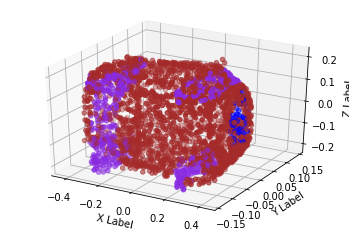

In [99]:
display_with_seg_mask(torch.cat([pcs[0].detach().cpu(), pred[0].unsqueeze(-1).detach().cpu()], dim = -1))

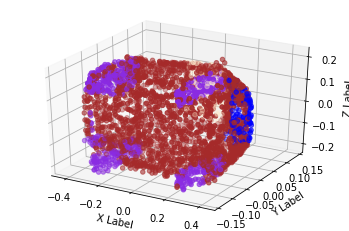

In [101]:
display_with_seg_mask(torch.cat([pcs[0].detach().cpu(), GTs[0].unsqueeze(-1).detach().cpu()], dim = -1))

# Part 3: Point Net ++, including multi height scaffolding with non local block for self attention

In [21]:
class NonLocalBlock(nn.Module):
  '''
  This module is very very similar to MultiHeadSelfAttention, however, it uses convolutions instead of dense layers to ensure
  that each of the points have the same operation and that the model remains permutation invariant
  '''
  def __init__(self, in_channel, inner_channel, num_heads):
    super().__init__()
    self.in_channel = in_channel
    self.inner_channel = inner_channel
    self.num_heads = num_heads
    self.Q = nn.Conv1d(self.in_channel, self.inner_channel * self.num_heads, kernel_size = 1)
    self.K = nn.Conv1d(self.in_channel, self.inner_channel * self.num_heads, kernel_size = 1)
    self.V = nn.Conv1d(self.in_channel, self.inner_channel * self.num_heads, kernel_size = 1)
    self.FinalLayer = nn.Conv1d(self.inner_channel * self.num_heads, self.in_channel, kernel_size = 1)
  def forward(self, x):
    '''
    x: Tensor(B, C, N)
    C = Channels
    N = # of points
    '''
    B, _, N = x.shape
    Queries = self.Q(x) # (B, 8I, N)
    Keys = self.K(x) # (B, 8I, N)
    Values = self.V(x) # (B, 8I, N)
    # Split Heads
    Queries = Queries.view(B, self.num_heads, self.inner_channel, N)
    Queries = Queries.view(B * self.num_heads, self.inner_channel, N)
    
    Keys = Keys.view(B, self.num_heads, self.inner_channel, N)
    Keys = Keys.view(B * self.num_heads, self.inner_channel, N)

    Values = Values.view(B, self.num_heads, self.inner_channel, N)
    Values = Values.view(B * self.num_heads, self.inner_channel, N) # (8B, I, N)

    Queries = Queries.transpose(1, 2) # (8B, N, I)
    # Compute Attention Matrix and Scale Down
    att_mat = torch.bmm(Queries, Keys) / math.sqrt(self.inner_channel)# (8B, N, N) 
    att_scores = F.softmax(att_mat, dim = -1)
    # Multiply Attention Weights by the Values
    attended_values = torch.bmm(Values, att_scores) # (8B, I, N)
    # Expand out all attention heads
    attended_values = attended_values.view(B, self.num_heads, self.inner_channel, N)
    attended_values = attended_values.view(B, self.num_heads * self.inner_channel, N)
    return self.FinalLayer(attended_values) + x

Define Key Functions for PointNet++
Note: These are Farthest Point Sampling and Query Ball Grouping 

In [22]:
class Sampler(nn.Module):
  '''
  This module when given an input point cloud will sample k points
  '''
  def __init__(self, device):
    super().__init__()
    self.device = device
  def Euclidean_Dist(self, set_A, point_B):
    '''
    Computes the distance matrix(Euclidean) between a set of points(matrix A) and a singular point
    set_A: Shape(N, C)
    point_B: Shape(C)
    return Dist_Mat: Shape(N), representing the distance between the N points and this one point
    '''
    N, C = set_A.shape
    # Span the single point across all n_points for one big square
    mult = torch.ones((N, C), device = self.device)
    points = mult * point_B # (N, C)
    # Subtract
    vals = (set_A - points) ** 2
    # Sum over the Channels
    summed = torch.sum(vals, dim = -1)
    return torch.sqrt(summed) # (N)
  def FarthestPointSampling(self, pointCloud, num_points):
    '''
    Preferred Method for sampling, samples points iteratively by computing the farthest distance
    pointCloud: Tensor(N, C)
    num_points: how many points to sample
    '''
    N, C = pointCloud.shape
    idx_to_true = {} # This represents the index of the remaining vector to the index in the original point cloud
    for i in range(1, N):
      idx_to_true[i - 1] = i # 0 in the remaining set is equal to the first point in the original point cloud
    # First, grab the initial point in the set, we just pick out the first one
    Set_Selected = [0] # We Guarentee to take out the first point, rest sampled
    Newest_Point = pointCloud[0, :] # (C), instead of contantly recomputing distances, we can just take the minimum between the new point and the current min dists and maximize that
    min_dist_from_selected = torch.zeros((N - 1), device = self.device)
    
    # Fill distances to infinity at first
    min_dist_from_selected[:] = float("Inf") # (N)
    
    Set_Remaining_Set = pointCloud[1:, :] # (N-1, :)
    # Begin Iterative Sampling of the point cloud
    while len(Set_Selected) < num_points:
      # Compute Distance matrix from the new point
      dist_mat = self.Euclidean_Dist(Set_Remaining_Set, Newest_Point)
      # Compute Minimum Euclidean Distance from Current Distance Matrix(TO get the shortest path from one point)
      min_dist_from_selected = torch.minimum(min_dist_from_selected, dist_mat) # (N)
      # Now, take out the maximum index(farthest index)
      _, max_idx = torch.max(min_dist_from_selected.unsqueeze(0), dim = -1) # (1)
      # get true idx in the point cloud
      pc_idx = idx_to_true[max_idx.item()]
      Set_Selected += [pc_idx] # Officially Selected Point
      Newest_Point = pointCloud[pc_idx, :]
      # Copy the idx_to_true values
      copy_idx_to_true = copy.deepcopy(idx_to_true) 
      for i in range(max_idx.item(), N - 2):
        copy_idx_to_true[i] = idx_to_true[i + 1]
      idx_to_true = copy_idx_to_true
      # Update the Distance Matrix to remove the selected entry entirely
      min_dist_from_selected_half = min_dist_from_selected[:max_idx]
      min_dist_from_selected_other = min_dist_from_selected[max_idx + 1:]
      # Concat
      min_dist_from_selected = torch.cat([min_dist_from_selected_half, min_dist_from_selected_other], dim = 0)
      # Also remove the selected point from the remaining set
      Set_Remaining_Set_half = Set_Remaining_Set[:max_idx, :]
      Set_Remaining_Set_other = Set_Remaining_Set[max_idx + 1:]
      Set_Remaining_Set = torch.cat([Set_Remaining_Set_half, Set_Remaining_Set_other], dim = 0)
    # now that we've sampled all of the points, we now have to create a new tensor and fill it in
    new_point_cloud = []
    for index in Set_Selected:
      new_point_cloud += [pointCloud[index, :]]
    return torch.stack(new_point_cloud)      
  def RandomPointSampling(self, point_cloud, num_points):
    '''
    Unadvised to utilize this for sampling, as it typically leads to a worse distribution of the point cloud
    point_cloud: Tensor(N, C)
    num_points: int
    '''
    Selected_Points = []
    Remaining_Points = point_cloud
    # Iteratively grab a sample of points
    for i in range(num_points):
      # Grab an index at random with random module
      idx = random.randint(0, Remaining_Points.shape[0] - 1)
      Selected_Points += [Remaining_Points[idx, :]]
      Remaining_Points_half = Remaining_Points[:idx, :]
      Remaining_Points_other = Remaining_Points[idx + 1:, :]
      Remaining_Points = torch.cat([Remaining_Points_half, Remaining_Points_other], dim = 0)
    return torch.stack(Selected_Points)

    

In [23]:
class Grouping(nn.Module):
  '''
  This Module groups the points based on distance, two methods available, KNN and Ball Grouping(preferred) 
  '''
  def __init__(self, device):
    super().__init__()
    self.device = device
  def Euclidean_distance(self, x, points):
    '''
    Efficiently Computes the distance from one point to all others in the 
    X: (C)
    points: (N, C)
    returns: (N), representing distance from this point
    '''
    N, C = points.shape
    # Copy X N times
    Ncopier = torch.ones((N, C), dtype = torch.float32, device = self.device)
    copied_X = x * Ncopier
    # Subtract from dimensions of all points, then square
    values = (points - copied_X) ** 2
    # Sum over dimensions
    summed = torch.sqrt(torch.sum(values, dim = -1))
    return summed
  def KNN(self, points, k):
    '''
    Performs Grouping for K closest points
    All groups have the same number of points, but will be stored in a list of tensors
    to maintain consistency with Ball Query Selection
    points: (N, C)
    k: how many closests values to take
    '''
    groups = []
    N, C = points.shape
    for i in range(N):
      center_point = points[i, :]
      # Compute distance vector
      distances = self.Euclidean_distance(center_point, points)
      _, candidates = torch.topk(distances, k, dim = 0, largest = False)
      pc = []
      for idx in candidates:
        pc += [points[idx, :]]
      groups += [torch.stack(pc)]
    return groups
  def ball_query(self, points, k, r):
    '''
    Performs radius ball query sampling, up to a max k points, all inside of the radius r
    points: shape(N, C)
    k: int, represents the max number of points from a given centre point 
    r: int, represents the radius or max distance from a certain poinr
    ''' 
    groups = []
    for i in range(points.shape[0]):
      centre_point = points[i, :] # (C)
      distances = self.Euclidean_distance(centre_point, points) # (N)
      # Again, map distances to the idx in the point cloud, this will be useful later
      dist_to_idx = {}
      for j in range(distances.shape[0]):
        if distances[j].item() <= r: # Filter out all not in radius distances
          if distances[j].item() in dist_to_idx:
            dist_to_idx[distances[j].item()] += [j]
          else:
            dist_to_idx[distances[j].item()] = [j]

      # Filter out the distances
      bools = distances <= r
      distances = sorted(distances[bools])
      # Choose top k
      distances = distances[:k]
      group = []
      for j in distances:
        group += dist_to_idx[j.item()]
      # Choose top k in group
      group = group[:k]
      pc = []
      for idx in group:
        pc += [points[idx, :]]
      groups += [torch.stack(pc)]
    return groups

PointNet Feature Processing Module, Due to Computational reasons, many of the layers inside of the PointNet Processing Model will be simplified(Ex. Visual Transformer)

In [24]:
class SimpleVT(nn.Module):
  '''
  Simple Visual Transformer model for Unit PointNet
  '''
  def __init__(self, in_channels, device):
    super().__init__()
    self.device = device
    self.in_channels = in_channels 
    self.conv1 = nn.Conv1d(self.in_channels, 128, kernel_size = 1)
    self.BN1 = nn.BatchNorm1d(128)
    self.conv2 = nn.Conv1d(128, 256, kernel_size = 1)
    self.BN2 = nn.BatchNorm1d(256)
    self.conv3 = nn.Conv1d(256, 256, kernel_size = 1)
    self.BN3 = nn.BatchNorm1d(256)
    # We are severely lowering dimensionality of the network to try and reduce parameter sizes
    self.Linear = nn.Linear(256, self.in_channels ** 2)
  def forward(self, x):
    '''
    x: Shape(B, C, N)
    '''
    # Reshape input
    B, _, _ = x.shape
    conv1 = self.BN1(F.relu(self.conv1(x)))
    conv2 = self.BN2(F.relu(self.conv2(conv1)))
    conv3 = self.conv3(conv2) # Add a Residual Connection
    features = self.BN3(F.relu(conv3 + conv2))
    # Max Pool over Features
    max_pooled, _ = torch.max(features, dim = -1) # (B, 512)
    transform = self.Linear(max_pooled) # (B, Output_Shape ^ 2)
    transform = transform.view(B, self.in_channels, self.in_channels) # (B, C, C)
    # Apply transformation
    transformed_x = torch.bmm(transform, x) # (B, C, N)
    # Compute the orthogonal loss
    orthogonal = torch.bmm(transform, transform.transpose(1, 2)) # (B, C, C)
    GT_one = np.identity(orthogonal.shape[1])
    GT = []
    for i in range(B):
      GT += [copy.deepcopy(GT_one)]
    GT = torch.tensor(GT, dtype = torch.float32, device = self.device)
    loss = torch.sum((GT - orthogonal) ** 2)
    return transformed_x, loss


In [25]:
class PointNetProcess(nn.Module):
  def __init__(self, in_channels, inner_channels1, inner_channels2, device, visual_transformer = False):
    '''
    Simple PointNet Processing module for hierarchical Learning
    '''
    super().__init__()
    self.visual_transformer = visual_transformer
    self.device = device
    self.in_channels = in_channels
    self.inner_channels1 = inner_channels1
    self.inner_channels2 = inner_channels2
    
    if self.visual_transformer:
      self.convTransform1 = nn.Conv1d(self.in_channels, 32, kernel_size = 1) # Trained to simply reduce dimensionality before the ViT
      self.BatchNormTransform = nn.BatchNorm1d(32)
      self.visualTransformer1 = SimpleVT(32, device)
      self.convTransform2 = nn.Conv1d(32, self.in_channels, kernel_size = 1) # Reinflates dimensionality
      self.BatchNormTransform2 = nn.BatchNorm1d(self.in_channels)

      self.convTransform3 = nn.Conv1d(self.inner_channels1, 64, kernel_size = 1)
      self.BatchNormTransform3 = nn.BatchNorm1d(64)
      self.visualTransformer2 = SimpleVT(64, device)
      self.convTransform4 = nn.Conv1d(64, self.inner_channels1, kernel_size = 1)
      self.BatchNormTransform4 = nn.BatchNorm1d(self.inner_channels1)

    self.NonLocalBlock = NonLocalBlock(self.inner_channels1, self.inner_channels1, 8) # Self Attention with 8 heads, preserve dimensions

    self.conv1 = nn.Conv1d(self.in_channels, self.inner_channels1, kernel_size = 1)
    self.BN1 = nn.BatchNorm1d(self.inner_channels1)

    # Residual Connection
    self.conv2 = PointResBlock(self.inner_channels1, self.inner_channels2)
  def forward(self, x):
    '''
    One group of points:
    x: Shape(B, N, C)
    This method extracts global features of the model
    '''
    lossVT1 = 0
    lossVT2 = 0

    # Transform the input to support convolution
    x = x.transpose(1, 2) # (B, C, N)
    if self.visual_transformer:
      # Reduce X's Dimensionality before continuing
      reduced_x = self.BatchNormTransform(F.relu(self.convTransform1(x)))
      transformed_x, lossVT1 = self.visualTransformer1(reduced_x)
      # Reinflate transformed_X
      transformed_x = self.BatchNormTransform2(F.relu(self.convTransform2(transformed_x))) # No residual connection as the visual transformer should learn what to change, and we don't want to reintroduce these pruned values
    else:
      transformed_x = x
    conv1 = self.BN1(F.relu(self.conv1(transformed_x)))
    # Reduce Conv1's Dimensionality 
    if self.visual_transformer:
      reduced_conv1 = self.BatchNormTransform3(F.relu(self.convTransform3(conv1)))
      transformed_conv1, lossVT2 = self.visualTransformer2(reduced_conv1)
      # Reinflate Transformed Variant
      transformed_conv1 = self.BatchNormTransform4(F.relu(self.convTransform4(transformed_conv1)))
    else:
      transformed_conv1 = conv1
    VTLOSS = lossVT1 + lossVT2
    # attend to
    attended_features = self.NonLocalBlock(transformed_conv1)
    # Final processing
    features = self.conv2(attended_features) # (B, 512, N), the batchnorm and relus are inside already
    # max pool
    global_features, _ = torch.max(features, dim = -1) # (B, 512)
    return global_features, VTLOSS


Sampling will go from N -> 1000 -> 500, then interpolation will bring it back up for segmentation, or a simple pointNet will be used for classification

In [26]:
class FeatureProcessing(nn.Module):
  def __init__(self, in_channel, inner_channel1, inner_channel2, device, visual_transformer = False):
    super().__init__()
    self.visual_transformer = visual_transformer
    self.device = device
    self.sampler = Sampler(self.device)
    self.grouper = Grouping(self.device)
    self.PointCloudProcessing = PointNetProcess(in_channel, inner_channel1, inner_channel2, self.device, visual_transformer=self.visual_transformer)
  def forward(self, x, num_samples):
    '''
    x: shape(B, N, C)
    '''
    B, _, _ = x.shape
    batched_groups = self.sample_and_group_batches(x, num_samples)
    group_features = []
    VTLOSS = torch.tensor((1),device = self.device, requires_grad= True, dtype= torch.float32) 
    for i in range(num_samples):
      grab_group = []
      for b in range(B):
        grab_group += [batched_groups[b][i]]
        # Stack the Values
      group_input = torch.stack(grab_group, dim = 0)
      # Process through pointNet
      global_features, VtLoss_tmp = self.PointCloudProcessing(group_input)
      VTLOSS = VTLOSS + VtLoss_tmp
      group_features += [global_features] # (B, C)
    return torch.stack(group_features, dim = -1).transpose(1, 2), VTLOSS
  def sample_and_group_batches(self, x, num_samples):
    '''
    Iteratively Samples and groups from each example
    x: (B, N, C)
    '''
    B, _, _ = x.shape
    batched_groups = []
    for i in range(B):
      ex = x[i, :, :] # (N, C)
      sampled = self.sampler.FarthestPointSampling(ex, num_samples) # (Num_Samples, C)
      batched_groups += [self.grouper.KNN(sampled, 16)] # These K
    return batched_groups

Full Model for Segmentation or Classification, with skip link connections

In [27]:
class PointNetPPClassification(nn.Module):
  '''
  This module Assembles all of the pointNet++ Parts into one clean thing for classification
  '''
  def __init__(self, num_classes, device):
    super().__init__()
    self.device = device
    self.num_classes = num_classes
    self.PointNet1 = FeatureProcessing(3, 64, 128, self.device, visual_transformer=True)
    self.PointNet2 = FeatureProcessing(128, 256, 512, self.device)
    self.FinalNet = PointNetProcess(512, 1024, 512, self.device)
    self.FC1 = nn.Linear(512, 128)
    self.BN1 = nn.BatchNorm1d(128)
    self.FC2 = nn.Linear(128, self.num_classes)
    self.Dropout = nn.Dropout(p = 0.3)
  def forward(self, x, num_samples1, num_samples2):
    '''
    Runs classification on the pointCloud
    x: Shape(B, N, C)
    Does Not softmax for numerical stability
    '''
    features1, VTLoss1 = self.PointNet1(x, num_samples1)
    features2, VTLoss2 = self.PointNet2(features1, num_samples2) 
    global_features, VTLoss3 = self.FinalNet(features2) # (B, C)
    # Get final Predictions
    FC1 = self.Dropout(self.BN1(F.relu(self.FC1(global_features)))) # (B, 128)
    return self.FC2(FC1), (VTLoss1 + VTLoss2 + VTLoss3) / 3


Solver PointNet++ Model to train on ModelNet10



In [28]:
class PointNetPPSolverModelNet(nn.Module):
  '''
  Solver for PointNet++
  '''
  def __init__(self, num_classes, device):
    super().__init__()
    self.device = device
    self.PointNetPP = PointNetPPClassification(num_classes, device)
    self.optim = optim.Adam(self.PointNetPP.parameters(), lr = 1e-3)
    self.criterion = nn.CrossEntropyLoss()
  def forward(self, x):
    '''
    Runs inference
    x: (B, N, C)
    '''
    self.eval()
    with torch.no_grad():
      predictions, _ = self.PointNetPP(x, 500, 250)
      logits = F.softmax(predictions, dim = -1) # (B, C)
      _, classes = torch.max(logits, dim = -1)
      return classes
  def batch_trainloader(self, trainloader, batch_size):
    '''
    randomizes the trainloader and splits it into the batches
    '''
    random_trainloader = copy.deepcopy(trainloader)
    random.shuffle(random_trainloader)
    batches = []
    GT = []
    for idx in range(0, len(random_trainloader), batch_size):
      batch_trainloader = random_trainloader[idx: idx + batch_size]
      batch_vals = []
      batch_GT = []
      for ex in batch_trainloader:
        for file_path in ex:
          batch_GT += [ex[file_path]]
        batch_vals += [torch.tensor(load_model_net(file_path), device = self.device, dtype = torch.float32)]
      batch_vals = torch.stack(batch_vals)
      batch_GT = torch.tensor(batch_GT, dtype = torch.long, device = self.device)
      batches += [batch_vals]
      GT += [batch_GT]
    return batches, GT
  def training_loop(self, trainloader, batch_size, NUM_EPOCHS):
    '''
    Trains the Model
    '''
    self.train()
    for EPOCH in tqdm.tqdm(range(NUM_EPOCHS)):
      # randomize and create batches for trainloader
      batches, GT = self.batch_trainloader(trainloader, batch_size)
      total_loss = 0.0
      for i in range(len(batches)):
        self.optim.zero_grad()
        batch = batches[i]
        GroundTruth = GT[i]
        class_scores, VTLoss = self.PointNetPP(batch, 500, 250)
        loss = self.criterion(class_scores, GroundTruth)
        loss = loss #+ VTLoss/5
        loss.backward()
        total_loss += loss.item()
        self.optim.step()
      print(f"EPOCH: {EPOCH}, loss: {total_loss / len(batches)}")

  def sample_batch(self, trainloader, num_ex):
    '''
    Randomly Grabs Num_Ex Training Examples from the trainloader
    '''
    # Copy and Randomize Trainloader
    random_trainloader = copy.deepcopy(trainloader)
    random.shuffle(random_trainloader)
    sample = random_trainloader[:num_ex]
    batched_GT = []
    batched_input = []
    for ex in sample:
      GT = []
      input_vals = []
      for file_path in ex:
        GT += [ex[file_path]]
      input_vals = torch.tensor(load_model_net(file_path), dtype = torch.float32, device = self.device)
      batched_input += [input_vals]
      batched_GT += [GT]
    return torch.stack(batched_input), torch.tensor(batched_GT, device = self.device)

In [104]:
%%capture
solver = PointNetPPSolverModelNet(10, device)
solver.to(device)

Modifications to the original model. The visual transformer in higher dimensional layers was a real computational bottleneck, since it is forced to output a N^2 activation transform, which is horrible in terms of memory and parameters(especially with the linear layer at the end!)
- So, the visual transformer was only kept in the first PointNet Layer with the intuition that it would modify the input point cloud but be less useful in later layers
- Similar approaches are taken in the Point Cloud Segmentation network

In [ ]:
solver.training_loop(modelNet_train_loader, 5, 200)

In [73]:
torch.save(solver.state_dict(), 'model.pth')

In [78]:
# Inference Loop
test_input, GT = solver.sample_batch(modelNet_train_loader, 10)

In [79]:
predicted_classes = solver(test_input)

In [ ]:
predicted_classes

In [ ]:
GT

Unit PointNet Needed for PointNet Segmentation Branch

In [29]:
class UnitPointNet(nn.Module):
  def __init__(self, in_channel, inner_channel1, inner_channel2, device, visual_transformer = False):
    '''
    Creates a Unit Point, parameters should be reduced pretty hard to maintain total trainable params lower than 10e^7
    '''
    super().__init__()
    self.visual_transformer = visual_transformer
    self.device = device
    # Store Necessary Variable
    self.in_channel = in_channel
    self.inner_channel1 = inner_channel1
    self.inner_channel2 = inner_channel2
    self.device = device

    # Visual Transformers
    if self.visual_transformer:
      self.convDownsample1 = nn.Conv1d(self.in_channel, 32, kernel_size = 1) # To downsample
      self.NormDownsample1 = nn.BatchNorm1d(32)
      self.VisualTransformer1 = SimpleVT(32, self.device)
      self.convUpsample1 = nn.Conv1d(32, self.in_channel, kernel_size = 1) # Reupsample
      self.NormUpsample1 = nn.BatchNorm1d(self.in_channel) # Reupsample

      self.convDownsample2 = nn.Conv1d(self.inner_channel1, 64, kernel_size = 1)
      self.NormDownsample2 = nn.BatchNorm1d(64)
      self.VisualTransformer2 = SimpleVT(64, self.device)
      self.convUpsample2 = nn.Conv1d(64, self.inner_channel1, kernel_size = 1)
      self.NormUpsample2 = nn.BatchNorm1d(self.inner_channel1)

    # Further Processing 
    self.conv1 = nn.Conv1d(self.in_channel, self.inner_channel1, kernel_size = 1)
    self.norm1 = nn.BatchNorm1d(self.inner_channel1)

    self.resBlock1 = PointResBlock(self.inner_channel1, self.inner_channel1)
    # Non Local Block
    self.NonLocalBlock = NonLocalBlock(self.inner_channel1, self.inner_channel1, 8) # 8 Head Self Attention
    # Final ResBlock
    self.resBlock2 = PointResBlock(self.inner_channel1, self.inner_channel2)
  def forward(self, x):
    '''
    This unit pointNet comes after interpolation, and it sets the channels necessary for concatenation
    x: Tensor(B, C, N)
    ''' 
    VTLoss1 = 0
    VTLoss2 = 0
    if self.visual_transformer:
      # To save on parameters, downsample the input
      Downsampled_X = self.NormDownsample1(F.relu(self.convDownsample1(x))) # (B, 24, N)
      transformed_x, VTLoss1 = self.VisualTransformer1(Downsampled_X) # (B, 24, N) 
      # Reupsample
      reupsampled_X = self.NormUpsample1(F.relu(self.convUpsample1(transformed_x)))
    else:
      reupsampled_X = x
    # Extract features
    features = self.norm1(F.relu(self.conv1(reupsampled_X)))
    if self.visual_transformer:
      # Downsample Features
      downsampled_features = self.NormDownsample2(F.relu(self.convDownsample1(x))) # (B, 48, N)
      transformed_features, VTLoss2 = self.VisualTransformer2(downsampled_features) # (B, 48, N)
      # Reupsample
      reupsampled_features = self.NormUpsample2(F.relu(self.convUpsample2(transformed_features)))
    else:
      reupsampled_features = features
    # Compute total ViT loss
    VTLOSS = VTLoss1 + VTLoss2
    # First ResBlock
    resBlock1 = self.resBlock1(reupsampled_features)
    # Attend to features
    attended_features = self.NonLocalBlock(resBlock1)
    return self.resBlock2(attended_features), VTLOSS

Solver for ShapeNet using PointNet++ 

In [30]:
class PointNetPPSegmentationNet(nn.Module):
  def __init__(self, num_seg_classes, device):
    super().__init__()
    self.device = device
    self.num_seg_classes = num_seg_classes
    # Same Beginning part of the Network
    self.PointNet1 = FeatureProcessing(3, 32, 64, self.device, visual_transformer = True)
    self.PointNet2 = FeatureProcessing(64, 128, 196, self.device) # Outputs: (B, N, C)
    # Segmentation Branch
    self.UnitPointNet1 = UnitPointNet(260, 128, 64, self.device) # to be concatted with orig input
    self.UnitPointNet2 = UnitPointNet(67, 128, self.num_seg_classes, self.device)
    # This branch takes in (B, C, N), so assure that transpose occurs
  def forward(self, x, num_sampled1, num_sampled2):
    # X: (B, N, C)
    features1, VTLoss1 = self.PointNet1(x, num_sampled1) # (B, N_1, C_1) 
    features2, VTLoss2 = self.PointNet2(features1, num_sampled2) # (B, N_2, C_2)
    # Transpose x
    features2 = features2.transpose(1, 2) # (B, C_2, N_2)
    # Transpose x and features 1
    features1 = features1.transpose(1, 2)
    x = x.transpose(1, 2) # (B, C, N)
    # Interpolate
    interpolated = F.interpolate(features2, size = features1.shape[-1]) # (B, C_2, N_1)
    # Concat across channels
    concatenated = torch.cat([interpolated, features1], dim = 1) # (B, C_2 + C_1, N_1)

    seg_block1, VTLoss3 = self.UnitPointNet1(concatenated) # (B, 128, N_1)
    # Interpolate again
    interpolated = F.interpolate(seg_block1, size = x.shape[-1]) # (B, 128, N)
    # Concat again
    concatenated = torch.cat([interpolated, x], dim = 1) # (B, 131, N)
    # Final Processing, Note: Again, no Softmax done
    final_scores, VTLoss4 = self.UnitPointNet2(concatenated)
    VTLOSS = (VTLoss1 + VTLoss2 + VTLoss3 + VTLoss4) / 4 # average vT losses
    return final_scores, VTLOSS

In [54]:
class SolverPointNetPPShapeNet(nn.Module):
  def __init__(self, num_classes, device):
    super().__init__()
    self.pointNet = PointNetPPSegmentationNet(num_classes, device)
    self.device = device
    self.optim = optim.Adam(self.pointNet.parameters())
    self.criterion = nn.CrossEntropyLoss()
  def batch_trainloader(self, trainloader, batch_size):
    '''
    Splits the trainloader into various batches(randomized)
    '''
    random_trainloader = copy.deepcopy(trainloader)
    random.shuffle(random_trainloader)
    batch_pc = []
    batch_GT = []
    batch_pad = []
    for idx in range(0, len(trainloader), batch_size):
      sample = random_trainloader[idx: idx + batch_size]
      unpadded_pcs = []
      batch_pad_idx = []
      for ex in sample:
        for file_name in ex:
          pass
        pc = torch.tensor(load_in_shapenet(file_path), device = self.device, dtype = torch.float32) # (N, 3)
        unpadded_pcs += [pc]
      # Find Max in the Batch
      maximum_num_points = 0
      for pc in unpadded_pcs:
        if pc.shape[0] > maximum_num_points:
          maximum_num_points = pc.shape[0]
      padded_pc = []
      padded_GT = []
      for pc in unpadded_pcs:
        # Create padded copy
        pad_pc = torch.zeros((maximum_num_points, 3), device = self.device, dtype = torch.float32)
        pad_GT = torch.zeros((maximum_num_points, 1), device = self.device, dtype = torch.long)
        pad_pc[:pc.shape[0], :] = pc[:, :-1]
        pad_GT[:pc.shape[0], :] = pc[:, -1].unsqueeze(-1)
        batch_pad_idx += [pc.shape[0]]
        padded_pc += [pad_pc]
        padded_GT += [pad_GT]
      padded_pc = torch.stack(padded_pc)
      padded_GT = torch.stack(padded_GT)
      batch_pad_idx = torch.tensor(batch_pad_idx, device = self.device, dtype = torch.long)
      batch_pad += [batch_pad_idx]
      batch_pc += [padded_pc]
      batch_GT += [padded_GT]
    return batch_pc,batch_GT,batch_pad
  def forward(self, pointClouds, pad_idx):
    '''
    Runs inference on the model
    pointClouds: (B, N, 3), padded according to pad_idx
    '''
    self.eval()
    with torch.no_grad():
      final_scores, VTLOSS = self.pointNet(pointClouds, 1000, 500) # (B, 50, N)
      # Softmax across dim = 1
      logits = F.softmax(final_scores, dim = 1)
      # argmax
      _, classes = torch.max(logits, dim = 1) # (B, N)
      # Create final list predictions
      final_pred = []
      B, _ = classes.shape
      for b in range(B):
        final_pred += [classes[b, :pad_idx[b]]]
      return final_pred
       
  def training_loop(self, trainloader, batch_size, NUM_EPOCHS):
    '''
    trains the model on the trainloader
    '''
    self.train()
    for EPOCH in tqdm.tqdm(range(NUM_EPOCHS)):
      # get batches
      batch_pc, batch_GT, batch_pad = self.batch_trainloader(trainloader, batch_size)
      total_loss = 0.0
      for batch_idx in range(len(batch_pc)):
        self.optim.zero_grad()
        pc = batch_pc[batch_idx] # (B, N, 3)
        GT = torch.squeeze(batch_GT[batch_idx]) # (B, N)
        pad_idx = batch_pad[batch_idx]
        class_scores, VTLOSS = self.pointNet(pc, 1000, 500) # (B, 50, N)
        tot_loss = torch.zeros((1), device = self.device, dtype = torch.float32, requires_grad = True)
        B, _, _, = pc.shape
        for b in range(B):
          pc_scores = class_scores[b, :, :].transpose(0, 1) # (N, 50)
          pc_GT = GT[b, :] # (N)
          # Filter down based on pad_idx
          pc_scores = pc_scores[:pad_idx[b]]
          pc_GT = pc_GT[:pad_idx[b]]
          loss = self.criterion(pc_scores, pc_GT)
          tot_loss = tot_loss + loss
        tot_loss.backward()
        self.optim.step()
        total_loss += loss.item()
      print(f'EPOCH: {EPOCH}, Loss: {total_loss / len(batch_pc)}')

  def sample(self, trainloader, sample_size):
    '''
    Samples a random sample from the trainloader 
    '''
    random_trainloader = copy.deepcopy(trainloader)
    random.shuffle(random_trainloader)
    sample = random_trainloader[:sample_size]
    batch = []
    GT = []
    padded_size = [] # Represents where the values were padded
    unpadded_batched = []
    for ex in sample:
      for file_path in ex:
        pass
      pc = torch.tensor(load_in_shapenet(file_path), dtype = torch.float32, device = self.device)
      unpadded_batched += [pc]
    # Compute Max and pad all to this value
    max_num_points = 0
    for pc in unpadded_batched:
      if pc.shape[0] > max_num_points:
        max_num_points = pc.shape[0]
    for pc in unpadded_batched:
      GT_pc = torch.zeros((max_num_points, 1), device = self.device, dtype = torch.long)
      pc_ex = torch.zeros((max_num_points, 3), device = self.device, dtype = torch.float32)
      # Fill GT_pc and ex
      GT_pc[:pc.shape[0], :] = pc[:, -1].unsqueeze(-1)
      pc_ex[:pc.shape[0], :] = pc[:, :-1]
      padded_size += [pc.shape[0]]
      batch += [pc_ex]
      GT += [pc_ex]
    return torch.stack(batch), torch.stack(GT), padded_size
      

In [55]:
%%capture
solver = SolverPointNetPPShapeNet(50, device)
solver.to(device)

In [ ]:
solver.load_state_dict(torch.load("./model.pth"))

In [40]:
solver.training_loop(trainloaderShapeNet, 2, 200)

EPOCH: 0, Loss: 4.121799513697624
EPOCH: 1, Loss: 3.911317765712738
EPOCH: 2, Loss: 3.869447782635689
EPOCH: 3, Loss: 3.833070307970047
EPOCH: 4, Loss: 3.780712440609932
EPOCH: 5, Loss: 3.618936225771904
EPOCH: 6, Loss: 3.3507315665483475
EPOCH: 7, Loss: 3.1566917449235916
EPOCH: 8, Loss: 3.075763314962387
EPOCH: 9, Loss: 2.849062129855156
EPOCH: 10, Loss: 2.5442783534526825
EPOCH: 11, Loss: 2.4708254486322403
EPOCH: 12, Loss: 2.509880617260933
EPOCH: 13, Loss: 2.448954463005066
EPOCH: 14, Loss: 2.353031873703003
EPOCH: 15, Loss: 2.241818830370903
EPOCH: 16, Loss: 2.1666349321603775
EPOCH: 17, Loss: 2.120906785130501
EPOCH: 18, Loss: 2.055286705493927
EPOCH: 19, Loss: 2.001173034310341
EPOCH: 20, Loss: 1.9020980298519135
EPOCH: 21, Loss: 1.7492835968732834
EPOCH: 22, Loss: 1.8229900598526
EPOCH: 23, Loss: 1.6557385176420212
EPOCH: 24, Loss: 1.6107034161686897
EPOCH: 25, Loss: 1.5370122864842415
EPOCH: 26, Loss: 1.4854586720466614
EPOCH: 27, Loss: 1.4332934990525246
EPOCH: 28, Loss: 1.3

KeyboardInterrupt: ignored

If you note above, I could have trained this further, but my Colab Runtime was running out so I won't(Also I might overuse my GPU this way)

In [42]:
torch.save(solver.state_dict(), "./model.pth")

In [60]:
sample, GT, padded_idx = solver.sample(trainloaderShapeNet, 1)

In [ ]:
padded_idx

In [62]:
predicted = solver(sample, padded_idx)[0]

In [70]:
predicted_pc = torch.cat([torch.squeeze(sample), predicted.unsqueeze(-1)], dim = -1)

In [73]:
gt_pc = torch.cat([sample, torch.squeeze(GT)], dim = 1)

In [ ]:
# The Ground Truth
display_with_seg_mask(gt_pc.detach().cpu().numpy())

In [ ]:
# My Predicted Segmentation Mask
display_with_seg_mask(predicted_pc.detach().cpu().numpy())

In [33]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(solver)

+--------------------------------------------------------------------------+------------+
|                                 Modules                                  | Parameters |
+--------------------------------------------------------------------------+------------+
|      pointNet.PointNet1.PointCloudProcessing.convTransform1.weight       |     96     |
|       pointNet.PointNet1.PointCloudProcessing.convTransform1.bias        |     32     |
|    pointNet.PointNet1.PointCloudProcessing.BatchNormTransform.weight     |     32     |
|     pointNet.PointNet1.PointCloudProcessing.BatchNormTransform.bias      |     32     |
| pointNet.PointNet1.PointCloudProcessing.visualTransformer1.conv1.weight  |    4096    |
|  pointNet.PointNet1.PointCloudProcessing.visualTransformer1.conv1.bias   |    128     |
|  pointNet.PointNet1.PointCloudProcessing.visualTransformer1.BN1.weight   |    128     |
|   pointNet.PointNet1.PointCloudProcessing.visualTransformer1.BN1.bias    |    128     |
| pointNet

3359573